![](https://www.finplus.co.in/wp-content/uploads/2017/10/Top-Categories-In-Online-Retail-In-India.jpg)

## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
We aim to segement the Customers based on RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

#### This kernel is based on the assignment by IIITB collaborated with upgrad

#### If this Kernel helped you in any way, some <font color="red"><b>UPVOTES</b></font> would be very much appreciated

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [56]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [57]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('./data/OnlineRetail_small.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    580296     23570     TRADITIONAL PICK UP STICKS GAME          3   
1    562558     37475         SET/4 COLOURFUL MIXING BOWLS         1   
2    555367    46000S         POLYESTER FILLER PAD 40x40cm        24   
3    570036    84032B  CHARLIE + LOLA RED HOT WATER BOTTLE         6   
4    536874     22374      AIRLINE BAG VINTAGE JET SET RED         1   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  02-12-2011 13:49       1.25     13780.0  United Kingdom  
1  05-08-2011 16:43       9.95     13451.0  United Kingdom  
2  02-06-2011 14:28       1.45     17900.0  United Kingdom  
3  07-10-2011 10:50       2.95     16358.0  United Kingdom  
4  03-12-2010 11:35       4.25     16891.0  United Kingdom

In [58]:
# shape of df

retail.shape

(54191, 8)

In [4]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54191 entries, 0 to 54190
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    54191 non-null  object 
 1   StockCode    54191 non-null  object 
 2   Description  54049 non-null  object 
 3   Quantity     54191 non-null  int64  
 4   InvoiceDate  54191 non-null  object 
 5   UnitPrice    54191 non-null  float64
 6   CustomerID   40557 non-null  float64
 7   Country      54191 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.3+ MB


In [5]:
# df description

retail.describe()

Quantity     UnitPrice    CustomerID
count  54191.000000  54191.000000  40557.000000
mean      10.940857      4.922923  15293.821782
std      350.584588     78.729222   1715.924049
min    -3167.000000      0.000000  12347.000000
25%        1.000000      1.250000  13959.000000
50%        3.000000      2.080000  15159.000000
75%       10.000000      4.130000  16791.000000
max    80995.000000  11586.500000  18287.000000

<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [6]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.26
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     25.16
Country         0.00
dtype: float64

In [7]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(40557, 8)

In [8]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [9]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

CustomerID  Amount
0    12347.0  210.30
1    12348.0   40.00
2    12349.0   82.84
3    12350.0   33.70
4    12352.0 -136.73

In [10]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

CustomerID  Frequency
0    12347.0         16
1    12348.0          1
2    12349.0          5
3    12350.0          2
4    12352.0          8

In [11]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

CustomerID  Amount  Frequency
0    12347.0  210.30         16
1    12348.0   40.00          1
2    12349.0   82.84          5
3    12350.0   33.70          2
4    12352.0 -136.73          8

In [12]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [13]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    580296     23570     TRADITIONAL PICK UP STICKS GAME          3   
1    562558     37475         SET/4 COLOURFUL MIXING BOWLS         1   
2    555367    46000S         POLYESTER FILLER PAD 40x40cm        24   
3    570036    84032B  CHARLIE + LOLA RED HOT WATER BOTTLE         6   
4    536874     22374      AIRLINE BAG VINTAGE JET SET RED         1   

          InvoiceDate  UnitPrice CustomerID         Country  Amount  \
0 2011-12-02 13:49:00       1.25    13780.0  United Kingdom    3.75   
1 2011-08-05 16:43:00       9.95    13451.0  United Kingdom    9.95   
2 2011-06-02 14:28:00       1.45    17900.0  United Kingdom   34.80   
3 2011-10-07 10:50:00       2.95    16358.0  United Kingdom   17.70   
4 2010-12-03 11:35:00       4.25    16891.0  United Kingdom    4.25   

               Diff  
0   6 days 23:01:00  
1 125 days 20:07:00  
2 189 days 22:22:00  
3  63 days 02:00:00  
4 371 days 01:15:00

In [15]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

CustomerID              Diff
0    12347.0   1 days 20:58:00
1    12348.0  74 days 23:37:00
2    12349.0  18 days 02:59:00
3    12350.0 309 days 20:49:00
4    12352.0  35 days 22:13:00

In [16]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

CustomerID  Diff
0    12347.0     1
1    12348.0    74
2    12349.0    18
3    12350.0   309
4    12352.0    35

In [17]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

CustomerID  Amount  Frequency  Recency
0    12347.0  210.30         16        1
1    12348.0   40.00          1       74
2    12349.0   82.84          5       18
3    12350.0   33.70          2      309
4    12352.0 -136.73          8       35

#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

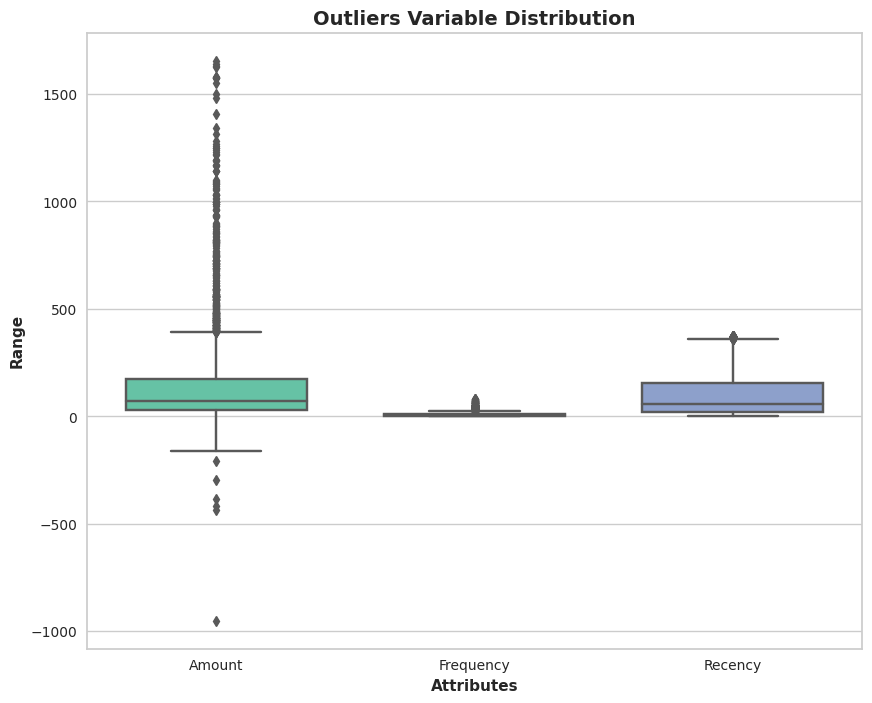

In [59]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [19]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [20]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3731, 3)

In [60]:
rfm_df_scaled.head()

Amount  Frequency   Recency
0  0.308502   0.638482 -0.950286
1 -0.509655  -0.727967 -0.242081
2 -0.303843  -0.363581 -0.785362
3 -0.539922  -0.636870  2.037758
4 -1.358703  -0.090291 -0.620437

In [21]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

Amount  Frequency   Recency
0  0.308502   0.638482 -0.950286
1 -0.509655  -0.727967 -0.242081
2 -0.303843  -0.363581 -0.785362
3 -0.539922  -0.636870  2.037758
4 -1.358703  -0.090291 -0.620437

<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [61]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [62]:
kmeans.labels_

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

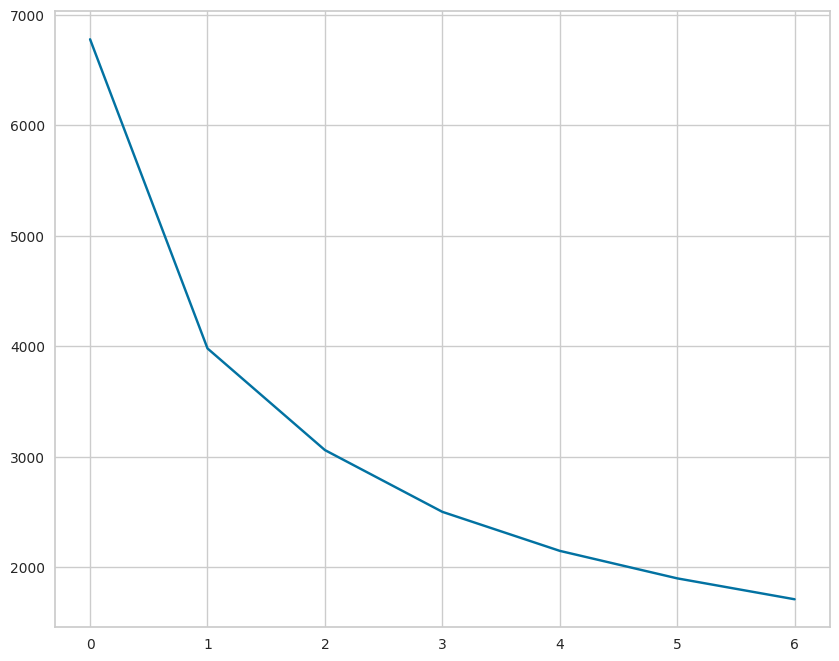

In [63]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [64]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.5429125283035207


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.5006051785512531


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.48078153395672907


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.4643171316524401


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.4118256786662067


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.376162382093913


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.3789389539168719


/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change 

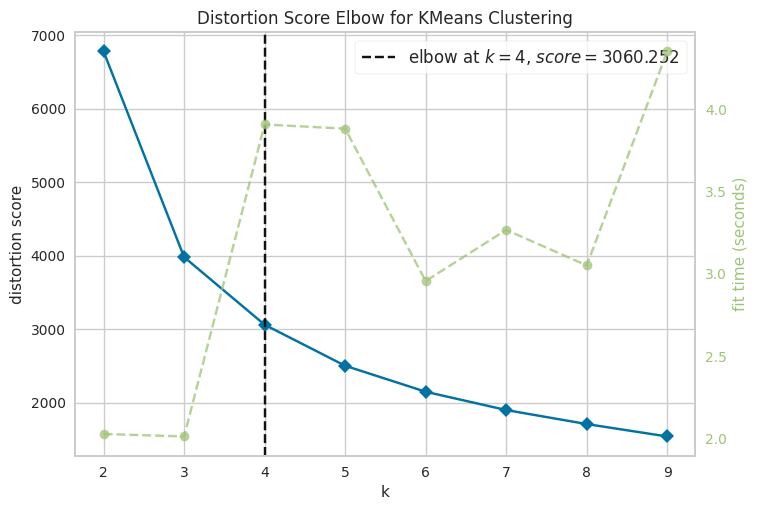

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(rfm_df_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

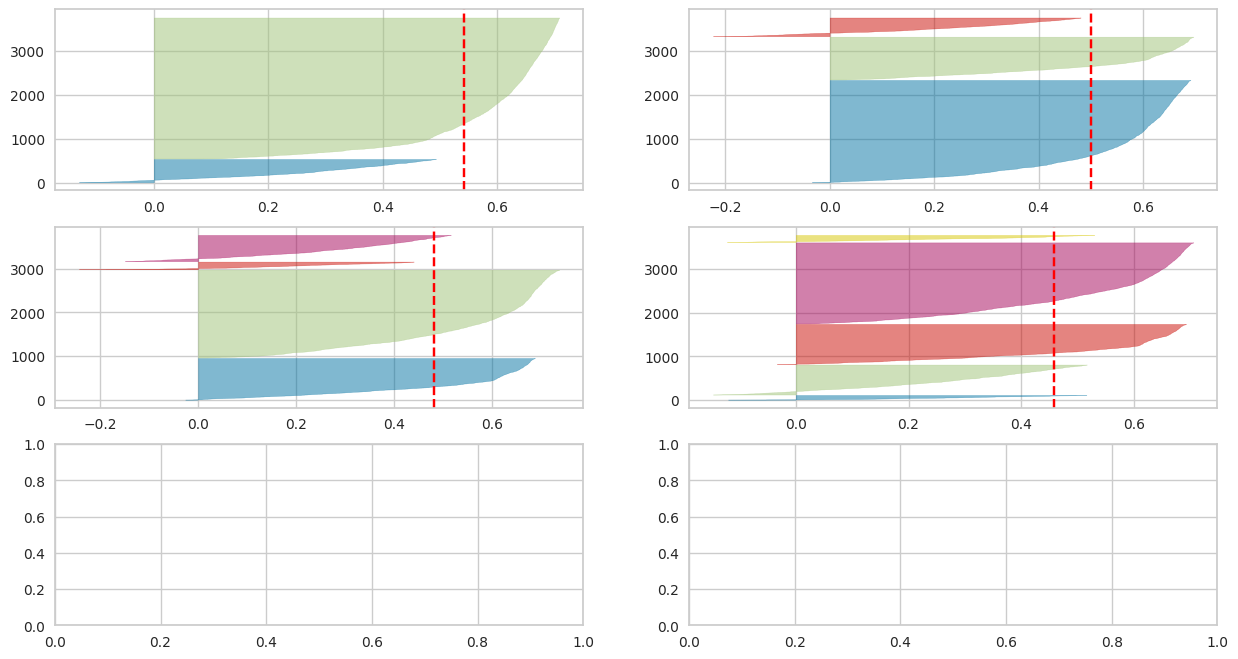

In [48]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer


fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=5, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm_df_scaled) 


1. For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line). The x-axis represents the Silhouette score. The clusters with K = 4 and 5 get eliminated as they don’t follow this condition.
2. There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points. For K = 2, the blue cluster has almost twice the width as compared to the green cluster. This blue cluster gets broken down into 2 sub-clusters for K = 3 and thus forms clusters of uniform size.

In [49]:
# Final model with k=3
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(rfm_df_scaled)

/home/wpan/project/teaching/BHT-DataScience-S23/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=5)

In [50]:
 kmeans.labels_

array([4, 0, 0, ..., 0, 3, 0], dtype=int32)

In [51]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

CustomerID  Amount  Frequency  Recency  Cluster_Id  Cluster_Labels
0    12347.0  210.30         16        1           4               0
1    12348.0   40.00          1       74           0               0
2    12349.0   82.84          5       18           0               0
3    12350.0   33.70          2      309           1               0
4    12352.0 -136.73          8       35           0               0

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

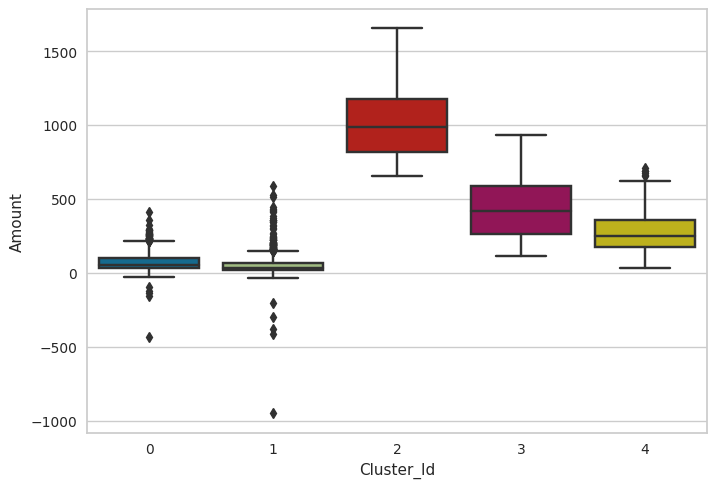

In [52]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

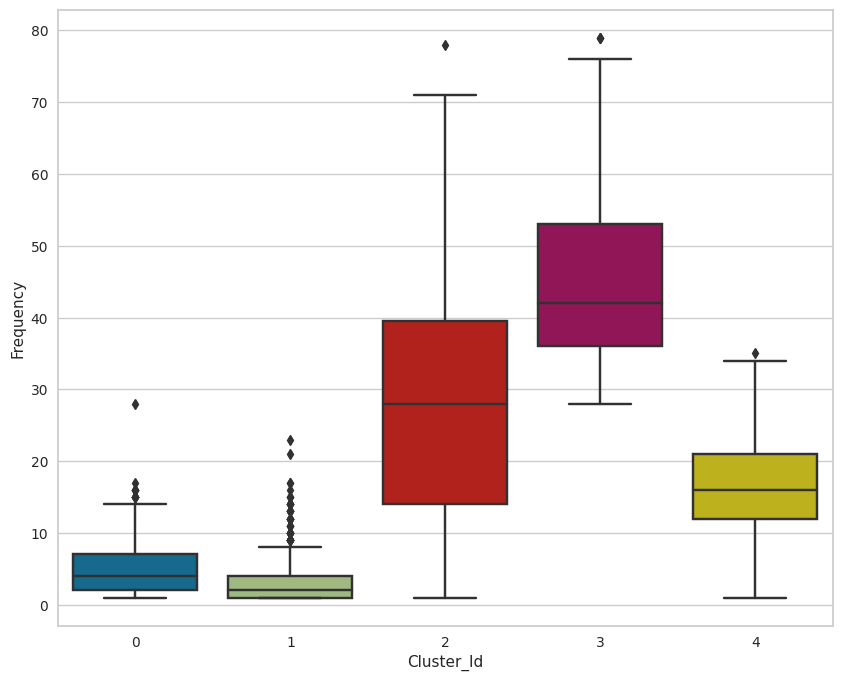

In [65]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

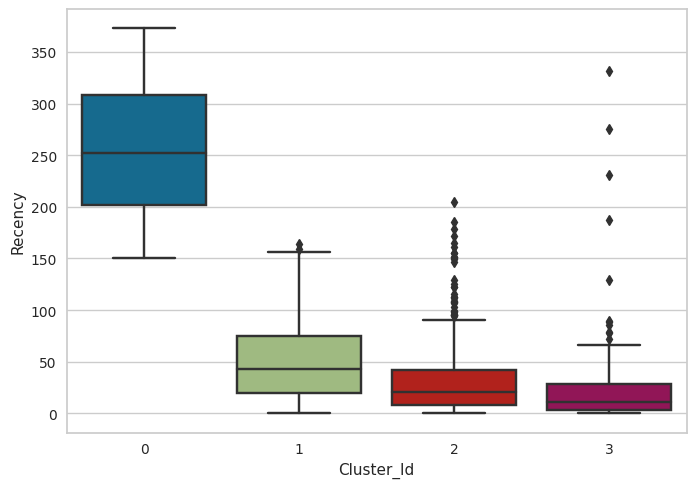

In [32]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

In [33]:
rfm_df_scaled.head()

Amount  Frequency   Recency
0  0.308502   0.638482 -0.950286
1 -0.509655  -0.727967 -0.242081
2 -0.303843  -0.363581 -0.785362
3 -0.539922  -0.636870  2.037758
4 -1.358703  -0.090291 -0.620437

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_df_scaled)
pca_df = pd.DataFrame.from_records(data=pca_data, columns=["x1","x2"])
pca_df["Cluster"] =  kmeans.labels_ + 1

In [67]:
pca_df.head()

x1        x2  Cluster
0  1.040509 -0.549741        1
1 -0.662773 -0.599879        8
2 -0.050296 -0.901929        8
3 -1.689954  1.404567        2
4 -0.598892 -1.136341        8

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

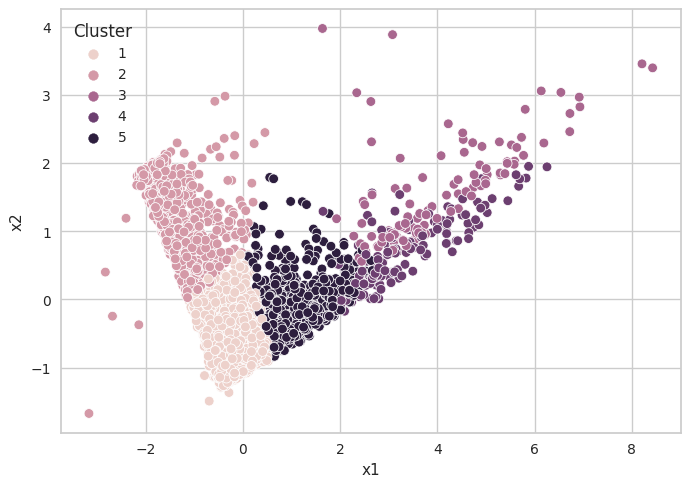

In [55]:
import seaborn as sns
sns.scatterplot(data=pca_df,x='x1', y='x2', hue='Cluster')

plt.show()



### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, 
- Divisive 
- Agglomerative.

**Single Linkage:<br>**

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
![](https://www.saedsayad.com/images/Clustering_single.png)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

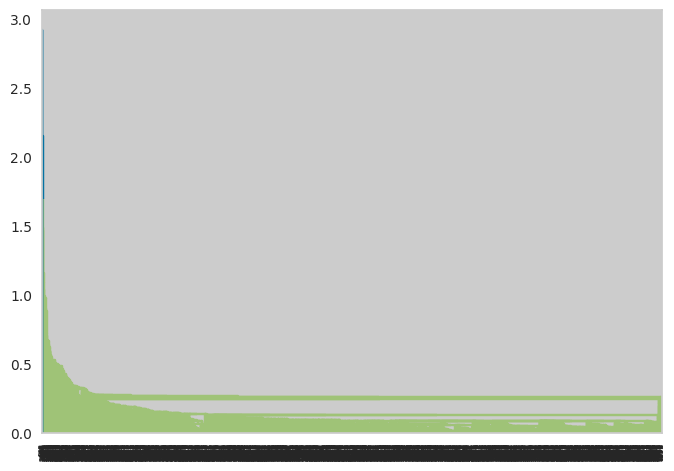

In [37]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage<br>**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points. 
![](https://www.saedsayad.com/images/Clustering_complete.png)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

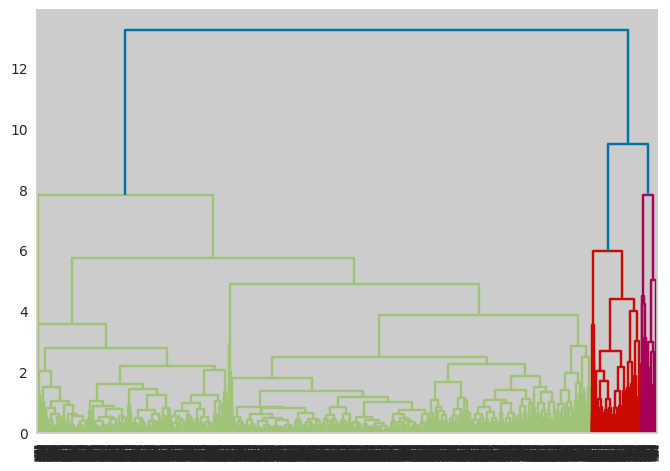

In [38]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage:<br>**

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
![](https://www.saedsayad.com/images/Clustering_average.png)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

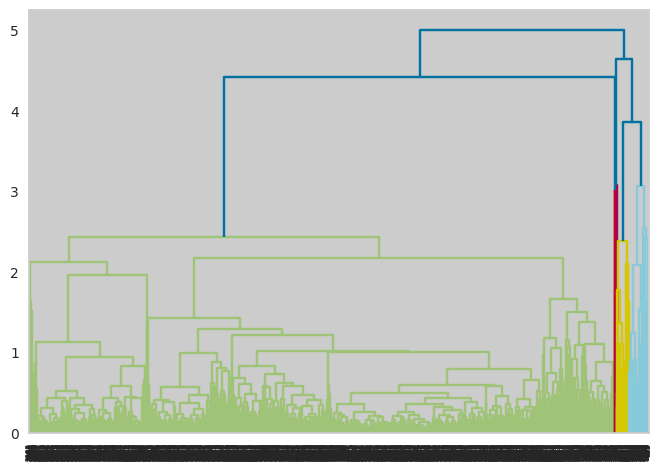

In [39]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Cutting the Dendrogram based on K

In [68]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=6).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 3, 0])

In [69]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

CustomerID  Amount  Frequency  Recency  Cluster_Id  Cluster_Labels
0    12347.0  210.30         16        1           4               0
1    12348.0   40.00          1       74           0               0
2    12349.0   82.84          5       18           0               0
3    12350.0   33.70          2      309           1               0
4    12352.0 -136.73          8       35           0               0

<Axes: xlabel='Cluster_Labels', ylabel='Amount'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

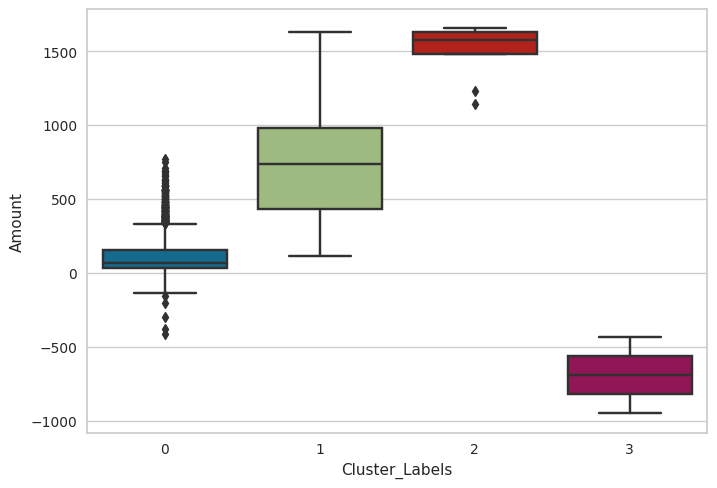

In [42]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Frequency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

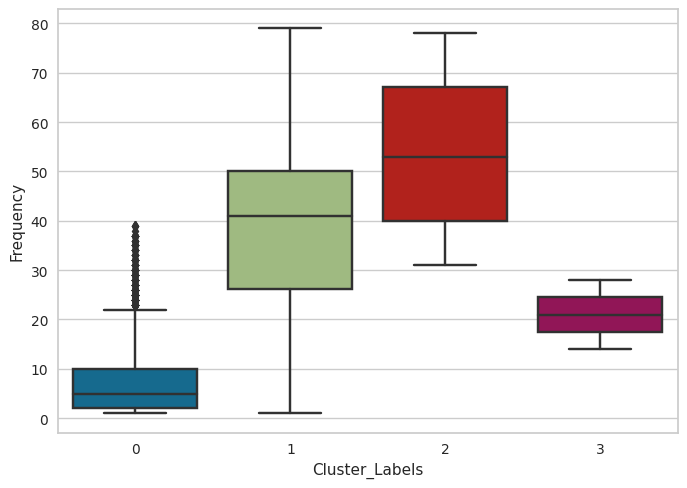

In [43]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Recency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

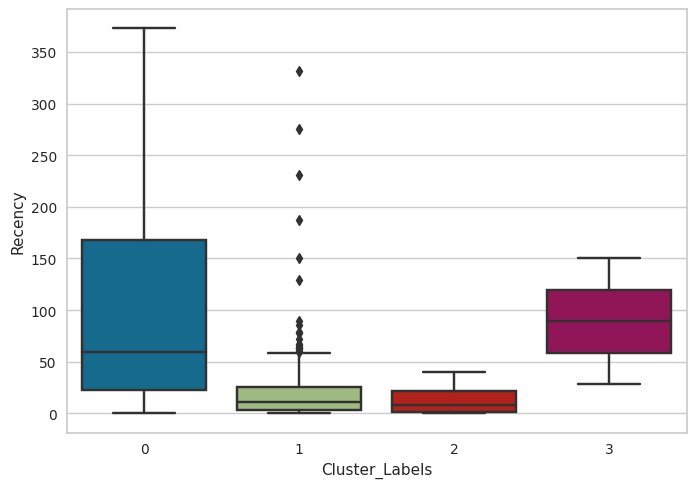

In [44]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

In [45]:
rfm.head()

CustomerID  Amount  Frequency  Recency  Cluster_Id  Cluster_Labels
0    12347.0  210.30         16        1           2               0
1    12348.0   40.00          1       74           1               0
2    12349.0   82.84          5       18           1               0
3    12350.0   33.70          2      309           0               0
4    12352.0 -136.73          8       35           1               0

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

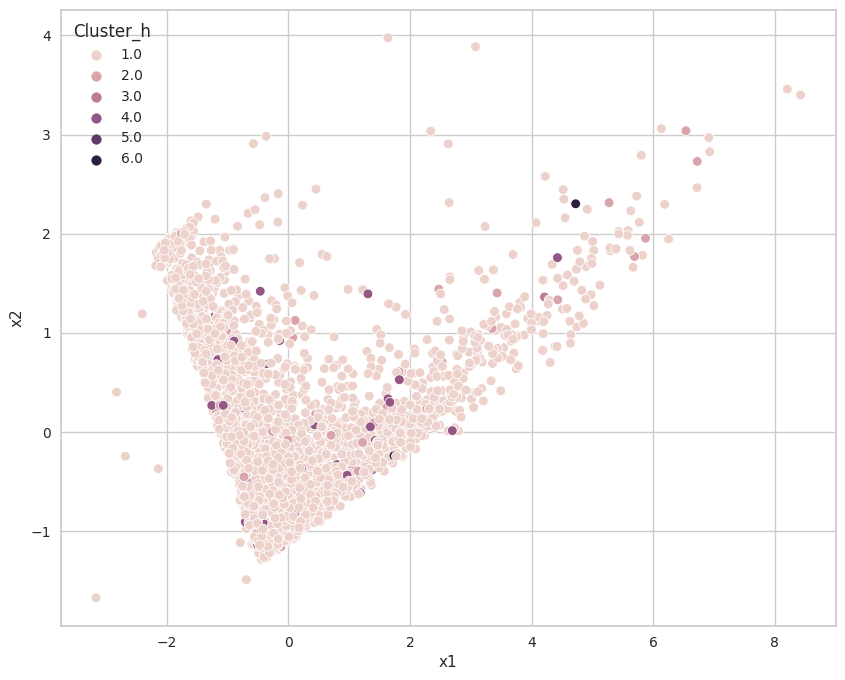

In [70]:
import seaborn as sns
pca_data_h = pca.fit_transform(rfm_df_scaled)
pca_df_h = pd.DataFrame.from_records(data=pca_data_h, columns=["x1","x2"])
pca_df["Cluster_h"] =  rfm.Cluster_Labels + 1
sns.scatterplot(data=pca_df,x='x1', y='x2', hue='Cluster_h')

plt.show()



<a id="5"></a> <br>
## Step 5 : Final Analysis

### Inference:
K-Means Clustering with 3 Cluster Ids
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

Hierarchical Clustering with 3 Cluster Labels
- Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster_Labels 2 are frequent buyers.
- Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.

### If this Kernel helped you in any way, some <font color="red"><b>UPVOTES</b></font> would be very much appreciated